# import

In [11]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from my_library.library import *
from pprint import pprint
import json
import requests
import sys
path_ =  '/Users/Owner/Desktop/bitflyer_api'
sys.path.append(path_)
from settings import API_settings as bapi


In [13]:
path_win1 = '/Users/Owner/Desktop/BitCoin/Data/btc_day_chart.csv'
path_win2= '/Users/Owner/Desktop/BitCoin/Data/btc_min_chart.csv'

In [3]:
def load_csv(load_path):
    df = pd.read_csv(load_path, header=None)
    df = df.rename(columns={
    df.columns[0]:'day',
    df.columns[1]:'open',
    df.columns[2]:'high',
    df.columns[3]:'low',
    df.columns[4]:'close',
    df.columns[5]:'volume'
    })
    df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
    df.set_index('day',inplace=True)
    return df

In [14]:
df = load_csv(path_win2)

   total_profit  profit rate  trade_count  max_profit  min_profit  \
1       -499458    -19978.32           15     1154185     -855103   

   mean_profit  cant_buy_count  
1     -33297.2               0  



<Figure size 432x288 with 0 Axes>

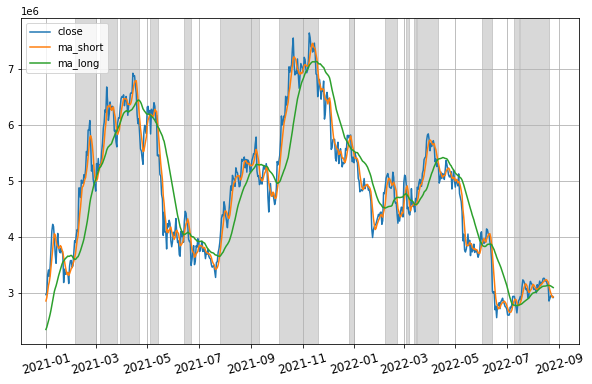

In [11]:
ts = TechnicalSimulation(hold_day=100)
ts.simulate(df,start_year=2021,end_year=2022)

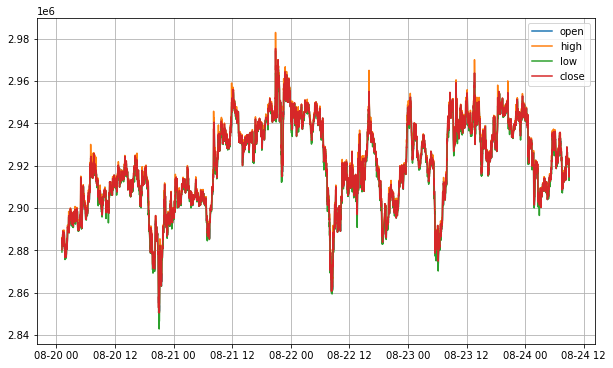

In [17]:

fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")

df_ = df[df.index.year==2022]

ax.plot(df_['open'],label='open')
ax.plot(df_['high'],label='high')
ax.plot(df_['low'],label='low')
ax.plot(df_['close'],label='close')


ax.grid()
ax.legend()
plt.show()

In [28]:
BASE_URL = 'https://coincheck.com'
url = BASE_URL + '/api/order_books'
params = {
    'limit': 1
}
r = requests.get(url, params=params)
r = r.json()
pprint(r)

{'asks': [['2937770.0', '0.02168']], 'bids': [['2936916.0', '0.087']]}


In [13]:
import ccxt
import datetime

In [14]:
bitflyer = ccxt.bitflyer({
'apiKey': bapi.API_KEY,
'secret': bapi.API_SECRET,
})

In [15]:

#------------------------------------------------------------------------------#
#log設定
import logging
logger = logging.getLogger('LoggingTest')
logger.setLevel(10)
fh = logging.FileHandler('log_mm_bf_' + datetime.datetime.now().strftime('%Y%m%d') + '_' + datetime.datetime.now().strftime('%H%M%S') + '.log')
logger.addHandler(fh)
sh = logging.StreamHandler()
logger.addHandler(sh)
formatter = logging.Formatter('%(asctime)s: %(message)s', datefmt="%Y-%m-%d %H:%M:%S")
fh.setFormatter(formatter)
sh.setFormatter(formatter)

#------------------------------------------------------------------------------#

# JPY残高を参照する関数
def get_asset():

    while True:
        try:
            value = bitflyer.fetch_balance()
            break
        except Exception as e:
            logger.info(e)
            time.sleep(1)
    return value



In [16]:
# JPY証拠金を参照する関数
def get_colla():

    while True:
        try:
            value = bitflyer.privateGetGetcollateral()
            break
        except Exception as e:
            logger.info(e)
            time.sleep(1)
    return value

In [18]:
get_colla()

{'collateral': '0.0',
 'open_position_pnl': '0.0',
 'require_collateral': '0.0',
 'keep_rate': '0.0',
 'margin_call_amount': '0.0',
 'margin_call_due_date': None}